In [3]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
df = pd.read_csv("../data/filtered_structured_data.csv")

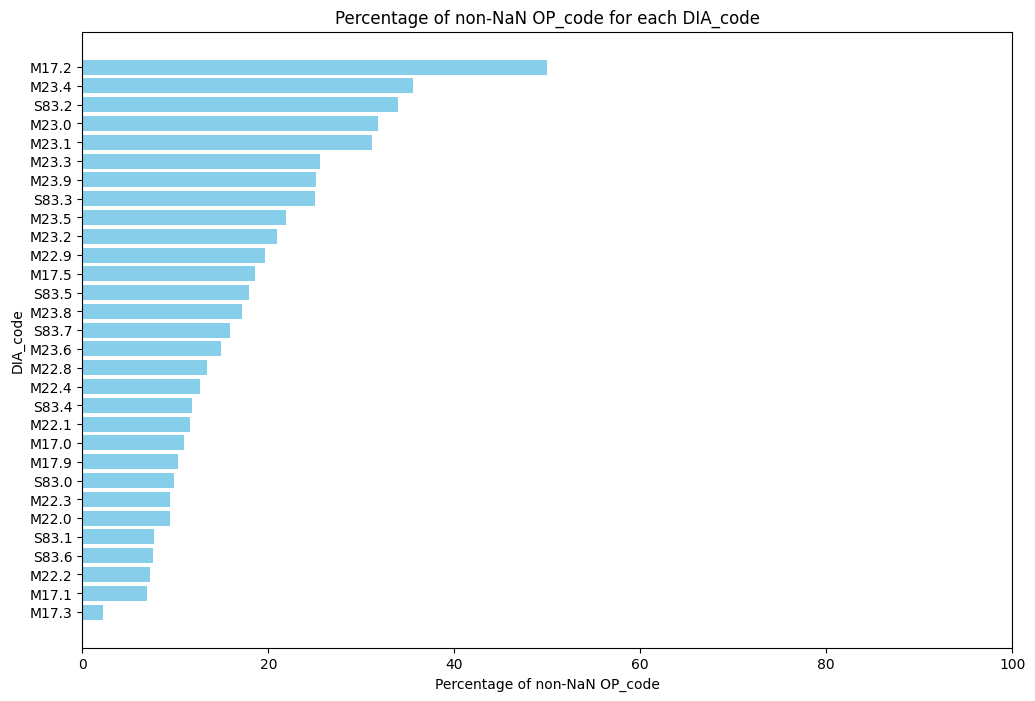

In [5]:
# Calculate the percentage of non-NaN OP_code for each DIA_code
df['DIA_code'] = df['DIA_code'].str[:5].to_frame()

percentage_non_nan = df.groupby('DIA_code')['OP_code'].apply(lambda x: x.notna().mean() * 100).reset_index()

# Rename the columns for better understanding
percentage_non_nan.columns = ['DIA_code', 'Percentage of non-NaN OP_code']

# Filter out DIA_code with 0% non-NaN OP_code
percentage_non_nan = percentage_non_nan[percentage_non_nan['Percentage of non-NaN OP_code'] > 0]

# Sort the values for better visualization
percentage_non_nan = percentage_non_nan.sort_values(by='Percentage of non-NaN OP_code', ascending=False)

# Plot the results using a horizontal bar plot
plt.figure(figsize=(12, 8))
plt.barh(percentage_non_nan['DIA_code'], percentage_non_nan['Percentage of non-NaN OP_code'], color='skyblue')
plt.xlabel('Percentage of non-NaN OP_code')
plt.ylabel('DIA_code')
plt.title('Percentage of non-NaN OP_code for each DIA_code')
plt.xlim(0, 100)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest percentage at the top
plt.show()

In [6]:
meniskus = [
    "M23.3",
    "S83.2", # Rupture
]
meniskus_low = [
    "M23.0", # Ganglion doesn't seem to urgent
    "M23.-",
    "M23.1", # something you have from birth
    "M23.2", # problems because of old rupture
    "M23.9"  # Same as M23.8
]
cruciate = [
    "M23.6", # Ruptur
    "S83.5",
    "S83.50", # might be rupture
    "S83.53", # Rupture
    "S83.54", # Rupture
    "S83.7" # Multiple areas
]
cruciate_low = [
    "M23.8", # Seems to be no rupture, rather weakness, still operations
    "S83.51", # Distorsion
    "S83.52", # Distorsion
]
other_urgent = [
    "S83.3", # Rupture Kniegelenkknorpel
    "S83.4", # Rupture Seitenband
    "S83.0",
    "S83.-"
]
other = [
    "M17",
    "M22",  
    "M23.4", # Freikörper, does have a lot of operations
    "M23.5", # instability
    "S83.1", # Only luxation
    "S83.6" # Distorsion somewhere
]

In [7]:
def createLabel(code):
    if any(elem in code for elem in meniskus):
        return "meniskus_urgent"
    elif any(elem in code for elem in meniskus_low):
        return "meniskus_low"
    elif any(elem in code for elem in cruciate):
        return "cruciate_urgent"
    elif any(elem in code for elem in cruciate_low):
        return "cruciate_low"
    elif any(elem in code for elem in other_urgent):
        return "other_urgent"
    elif any(elem in code for elem in other):
        return "other"
    else:
        return "unknown"
    
df['label'] = df['DIA_code'].apply(createLabel)

In [8]:
df.to_csv("../data/classification_dataset.csv")

45257


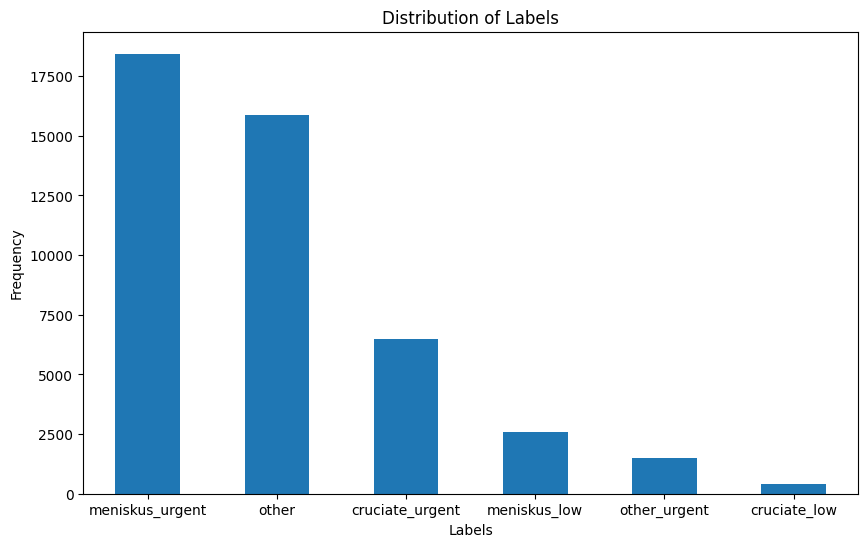

In [9]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
label_column = 'label'
cols = ['ANA', 'EXA', 'age', 'sex']
df['data'] = df[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
df['data'].head()
# Get the minimum count of samples among all labels
min_count = df[label_column].value_counts().min()

# Create a new DataFrame with balanced samples
balanced_df = df # pd.concat([df[df['DIA_code'] == label].sample(min_count, random_state=42) for label in df['DIA_code'].unique()])
texts = balanced_df['data']

encoder = OneHotEncoder()
labels = encoder.fit_transform(df[label_column].to_frame()).toarray()
num_classes = len(encoder.categories_[0])
print(len(df))
label_counts = balanced_df[label_column].value_counts()

# Plot the distribution of labels
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [10]:
balanced_df.to_csv("../data/balanced_classification_dataset.csv")